In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

RANDOM_STATE = 42
kmeans_ks = list(range(5, 21))
dbscan_eps = [0.2, 0.3, 0.4, 0.5, 0.6, 0.75]
dbscan_min_samples = [3, 4, 5, 6,]
agg_ks = list(range(4, 21))
agg_linkages = ["ward", "complete", "average"]

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

np.random.seed(RANDOM_STATE)

# Вспомогательные функции

In [2]:
def safe_cluster_metrics(X, labels):
    """Считает метрики; возвращает None, если метрика неприменима."""
    unique = np.unique(labels)
    # Нужно минимум 2 кластера
    if len(unique) < 2:
        return None

    # Нельзя, чтобы все точки были в одном кластере
    if len(unique) == 1:
        return None

    # silhouette требует, чтобы все кластеры имели >1 точки (часто, но не всегда)
    # В sklearn silhouette_score может падать, если какой-то кластер пуст/особый.
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = None

    try:
        db = float(davies_bouldin_score(X, labels))
    except Exception:
        db = None

    try:
        ch = float(calinski_harabasz_score(X, labels))
    except Exception:
        ch = None

    return {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

def pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE):
    """PCA(2D) именно для визуализации."""
    p = PCA(n_components=2, random_state=RANDOM_STATE)
    return p.fit_transform(X_scaled)

def plot_2d_embedding(emb2d, labels, title, name_algo = "algo", n = 1):
    plt.figure(figsize=(7, 5))
    ##plt.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, s=18)
    unique = sorted(set(labels))
    for lab in unique:
        mask = labels == lab
        if lab == -1:
            plt.scatter(emb2d[mask, 0], emb2d[mask, 1], s=20, marker="x", label="noise (-1)")
        else:
            plt.scatter(emb2d[mask, 0], emb2d[mask, 1], s=20, label=f"cluster {lab}")
    plt.legend(loc="best")
    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.grid(True, alpha=0.2)
    plt.savefig(f"artifacts/figures/{name_algo}_dataset{n}.png", dpi=300)
    plt.show()

def summarize_labels(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique.tolist(), counts.tolist()))

def summarize_labels(labels):
    """Короткая статистика по разметке: число кластеров, доля шума."""
    labels = np.asarray(labels)
    n_noise = np.sum(labels == -1)
    n_points = len(labels)
    clusters = sorted([c for c in set(labels) if c != -1])
    return {
        "n_points": n_points,
        "n_clusters": len(clusters),
        "n_noise": int(n_noise),
        "noise_share": float(n_noise / n_points)
    }

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

# Первичный анализ

## S07-hw-dataset-01.csv 

In [3]:
file1 = 'data/S07-hw-dataset-01.csv'
data1 =  pd.read_csv(file1, sep=",")

In [4]:
data1

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213
...,...,...,...,...,...,...,...,...,...
11995,11995,15.358432,56.974156,-1.089617,-95.891749,8.909345,26.123207,-20.786813,-0.681086
11996,11996,-5.781842,71.198182,-0.201762,-54.336472,4.903560,-3.287724,-48.875539,0.172566
11997,11997,-7.573306,70.017900,-0.159869,17.167497,-3.809988,-5.356308,-98.751869,0.836130
11998,11998,13.856888,88.341387,-1.429989,-101.905925,10.759963,29.308895,-19.837802,0.300104


In [5]:
data1.head(10)

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213
5,5,-9.155108,80.803958,-0.023064,-42.562391,2.681999,-10.450216,52.285727,0.134157
6,6,-13.414198,-45.224459,0.016343,23.198649,0.275342,4.845267,40.734814,0.040547
7,7,-15.303931,-39.539061,0.198038,21.117504,0.334350,1.308574,17.347164,0.378773
8,8,-15.154668,-34.099503,0.215049,18.059247,1.937555,2.834771,-87.429349,-0.191803
9,9,0.673476,-82.966506,-0.066941,70.082996,-11.262309,-7.221289,-28.222359,-0.383327


In [6]:
data1.describe()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


In [7]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


Все признаки имеют тип данных float64 (числовые) и не имеют пропусков

In [8]:
X1 = data1.drop(columns=['sample_id'])
id1 = data1['sample_id']

In [9]:
X1

,f01,f02,f03,f04,f05,f06,f07,f08
0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213
...,...,...,...,...,...,...,...,...
11995,15.358432,56.974156,-1.089617,-95.891749,8.909345,26.123207,-20.786813,-0.681086
11996,-5.781842,71.198182,-0.201762,-54.336472,4.903560,-3.287724,-48.875539,0.172566
11997,-7.573306,70.017900,-0.159869,17.167497,-3.809988,-5.356308,-98.751869,0.836130
11998,13.856888,88.341387,-1.429989,-101.905925,10.759963,29.308895,-19.837802,0.300104


In [10]:
id1

0            0
1            1
2            2
3            3
4            4
         ...  
11995    11995
11996    11996
11997    11997
11998    11998
11999    11999
Name: sample_id, Length: 12000, dtype: int64

## S07-hw-dataset-02.csv 

In [11]:
file2 = 'data/S07-hw-dataset-02.csv'
data2 =  pd.read_csv(file2, sep=",")

In [12]:
data2

,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472
...,...,...,...,...
7995,7995,0.396444,-0.258826,1.866578
7996,7996,0.540757,-0.290802,5.437638
7997,7997,0.672079,0.675018,-2.488673
7998,7998,1.871350,0.290634,-0.852787


In [13]:
data2.head()

,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


In [14]:
data2.describe()

,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


In [15]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


Все признаки имеют тип данных float64 (числовые) и не имеют пропусков

In [16]:
X2 = data2.drop(columns = ['sample_id'])
Y2 = data2['sample_id']

In [17]:
X2

,x1,x2,z_noise
0,0.098849,-1.846034,21.288122
1,-1.024516,1.829616,6.072952
2,-1.094178,-0.158545,-18.938342
3,-1.612808,-1.565844,-11.629462
4,1.659901,-2.133292,1.895472
...,...,...,...
7995,0.396444,-0.258826,1.866578
7996,0.540757,-0.290802,5.437638
7997,0.672079,0.675018,-2.488673
7998,1.871350,0.290634,-0.852787


In [18]:
Y2

0          0
1          1
2          2
3          3
4          4
        ... 
7995    7995
7996    7996
7997    7997
7998    7998
7999    7999
Name: sample_id, Length: 8000, dtype: int64

## S07-hw-dataset-03.csv 

In [19]:
file3 = 'data/S07-hw-dataset-03.csv'
data3 = pd.read_csv(file3, sep = ',')

In [20]:
data3

,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899
...,...,...,...,...,...
14995,14995,0.445659,-7.395811,1.128535,3.262734
14996,14996,0.258364,-6.267180,1.570404,1.735637
14997,14997,0.104631,-7.394277,0.428989,2.589123
14998,14998,-0.660232,-6.329977,1.420440,2.402324


In [21]:
data3.head()

,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899


In [22]:
data3.describe()

,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865


In [23]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB


Все признаки имеют тип данных float64 (числовые) и не имеют пропусков

In [24]:
X3 = data3.drop(columns = ['sample_id'])
id3 = data3['sample_id']

In [25]:
X3

,x1,x2,f_corr,f_noise
0,-2.710470,4.997107,-1.015703,0.718508
1,8.730238,-8.787416,3.953063,-1.105349
2,-1.079600,-2.558708,0.976628,-3.605776
3,6.854042,1.560181,1.760614,-1.230946
4,9.963812,-8.869921,2.966583,0.915899
...,...,...,...,...
14995,0.445659,-7.395811,1.128535,3.262734
14996,0.258364,-6.267180,1.570404,1.735637
14997,0.104631,-7.394277,0.428989,2.589123
14998,-0.660232,-6.329977,1.420440,2.402324


In [26]:
id3

0            0
1            1
2            2
3            3
4            4
         ...  
14995    14995
14996    14996
14997    14997
14998    14998
14999    14999
Name: sample_id, Length: 15000, dtype: int64

## S07-hw-dataset-04.csv 

In [27]:
file4 = 'data/S07-hw-dataset-04.csv'
data4 = pd.read_csv(file4, sep = ',')

In [28]:
data4

,sample_id,cat_a,cat_b,n01,n02,n03,n04,n05,n06,n07,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
0,0,B,X,-4.827501,-24.507466,-7.852963,0.771781,28.297884,-4.493911,-42.769449,...,24.597176,-26.354320,4.543397,-19.549036,-3.051332,-5.538587,-3.084457,5.499629,-6.128896,3.132067
1,1,F,V,51.302500,NaN,5.534737,51.305464,-8.027553,28.297548,NaN,...,-18.216260,8.527932,17.202115,-30.452260,0.855326,1.199066,3.597555,-2.239703,2.932710,0.473145
2,2,A,W,-4.820828,-2.625385,27.891578,1.523041,-5.776687,-16.298523,2.462937,...,-48.260775,9.313232,12.323411,55.081325,-3.945606,-0.280540,-0.130583,-7.353205,-2.942836,1.460477
3,3,B,X,-2.627573,-25.063639,-9.450011,-8.344669,22.371118,-11.525848,-43.762607,...,24.700663,-25.466915,-3.398665,-18.174541,0.438229,3.152556,3.859283,-2.678769,-2.213923,-4.724639
4,4,C,Y,-11.415710,-8.692169,48.636163,14.661826,-39.634618,10.769075,40.187536,...,-79.710383,-13.694253,41.575892,-9.498640,1.529608,-1.641347,3.500090,3.111257,1.475232,-1.321676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,B,Y,-12.919119,-9.267355,47.395822,16.511540,-41.729247,7.799989,44.328290,...,-78.743409,-11.366750,36.477397,NaN,0.297751,1.243343,-1.600864,1.911969,NaN,0.670396
9996,9996,F,V,52.254641,-5.019958,0.993982,53.264712,-14.450314,36.732040,28.145815,...,-23.303770,17.161685,23.882319,-34.536261,1.294916,NaN,-7.103462,-3.585500,-1.395671,2.595430
9997,9997,E,U,33.523186,37.236276,-25.926850,2.988096,19.835512,13.452346,-10.263819,...,16.698474,16.473067,-16.313042,16.091088,0.112241,2.087142,-0.415373,-2.160709,2.007264,-1.058989
9998,9998,C,Y,-14.673242,-11.949793,48.937510,13.509319,-39.930625,6.829405,37.074823,...,-75.828139,NaN,39.972907,-6.301002,3.193872,-3.664677,4.156100,2.483901,-0.709864,-3.844730


In [29]:
data4.head()

,sample_id,cat_a,cat_b,n01,n02,n03,n04,n05,n06,n07,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
0,0,B,X,-4.827501,-24.507466,-7.852963,0.771781,28.297884,-4.493911,-42.769449,...,24.597176,-26.354320,4.543397,-19.549036,-3.051332,-5.538587,-3.084457,5.499629,-6.128896,3.132067
1,1,F,V,51.302500,NaN,5.534737,51.305464,-8.027553,28.297548,NaN,...,-18.216260,8.527932,17.202115,-30.452260,0.855326,1.199066,3.597555,-2.239703,2.932710,0.473145
2,2,A,W,-4.820828,-2.625385,27.891578,1.523041,-5.776687,-16.298523,2.462937,...,-48.260775,9.313232,12.323411,55.081325,-3.945606,-0.280540,-0.130583,-7.353205,-2.942836,1.460477
3,3,B,X,-2.627573,-25.063639,-9.450011,-8.344669,22.371118,-11.525848,-43.762607,...,24.700663,-25.466915,-3.398665,-18.174541,0.438229,3.152556,3.859283,-2.678769,-2.213923,-4.724639
4,4,C,Y,-11.415710,-8.692169,48.636163,14.661826,-39.634618,10.769075,40.187536,...,-79.710383,-13.694253,41.575892,-9.498640,1.529608,-1.641347,3.500090,3.111257,1.475232,-1.321676


In [30]:
data4.describe()

,sample_id,n01,n02,n03,n04,n05,n06,n07,n08,n09,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
count,10000.00000,9826.000000,9811.000000,9801.000000,9808.000000,9799.000000,9817.000000,9796.000000,9806.000000,9805.000000,...,9785.000000,9804.000000,9829.000000,9793.000000,9815.000000,9776.000000,9803.000000,9789.000000,9798.000000,9805.000000
mean,4999.50000,17.348435,-2.057620,7.908302,14.269157,0.900590,5.832787,-0.840875,-4.888128,3.184200,...,-12.716502,-0.506241,8.360226,0.026943,0.039297,-0.037155,0.028512,-0.030738,-0.018685,-0.030254
std,2886.89568,22.578551,19.043410,25.637807,18.815319,20.981294,13.221646,26.583849,15.466271,32.208740,...,37.290305,14.336833,17.754646,26.121335,3.009995,3.020813,3.028106,3.000090,3.014209,3.014573
min,0.00000,-22.437090,-37.546998,-38.136412,-23.374316,-45.914070,-20.650038,-60.297304,-44.464550,-70.904880,...,-89.640783,-35.102360,-25.014050,-49.423300,-11.225848,-14.446922,-10.840777,-11.679259,-11.437909,-11.491223
25%,2499.75000,-3.975438,-14.200552,-8.591513,-1.223379,-5.086756,-4.532057,-13.554720,-17.352641,-11.460490,...,-41.284671,-11.563652,-2.123576,-19.425213,-1.973213,-2.082235,-2.007628,-2.074500,-2.051778,-2.074396
50%,4999.50000,22.042807,-6.532183,0.350400,10.069142,2.413111,7.391953,-2.429024,-7.095546,13.258691,...,-1.145681,2.491416,6.691365,-8.464171,0.037806,-0.033336,0.031588,-0.043127,-0.015441,-0.015903
75%,7499.25000,37.535647,2.092197,30.725630,29.807101,18.398883,13.033076,16.095731,3.909111,20.188426,...,18.916379,11.903004,14.939690,16.861978,2.048648,2.019027,2.056870,1.980217,2.013964,2.031215
max,9999.00000,65.446912,43.326647,60.185729,65.094588,42.527554,39.933274,48.591236,31.335431,64.696045,...,49.157087,22.452135,46.892903,61.540902,11.002135,11.394631,11.936846,10.663960,10.665988,13.755203


In [31]:
data4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  10000 non-null  int64  
 1   cat_a      10000 non-null  object 
 2   cat_b      10000 non-null  object 
 3   n01        9826 non-null   float64
 4   n02        9811 non-null   float64
 5   n03        9801 non-null   float64
 6   n04        9808 non-null   float64
 7   n05        9799 non-null   float64
 8   n06        9817 non-null   float64
 9   n07        9796 non-null   float64
 10  n08        9806 non-null   float64
 11  n09        9805 non-null   float64
 12  n10        9811 non-null   float64
 13  n11        9796 non-null   float64
 14  n12        9798 non-null   float64
 15  n13        9803 non-null   float64
 16  n14        9802 non-null   float64
 17  n15        9814 non-null   float64
 18  n16        9809 non-null   float64
 19  n17        9788 non-null   float64
 20  n18    

In [32]:
total = data4.isna().sum()
share = total / len(data4)
total

sample_id      0
cat_a          0
cat_b          0
n01          174
n02          189
n03          199
n04          192
n05          201
n06          183
n07          204
n08          194
n09          195
n10          189
n11          204
n12          202
n13          197
n14          198
n15          186
n16          191
n17          212
n18          212
n19          187
n20          203
n21          215
n22          196
n23          171
n24          207
n25          185
n26          224
n27          197
n28          211
n29          202
n30          195
dtype: int64

In [33]:
share

sample_id    0.0000
cat_a        0.0000
cat_b        0.0000
n01          0.0174
n02          0.0189
n03          0.0199
n04          0.0192
n05          0.0201
n06          0.0183
n07          0.0204
n08          0.0194
n09          0.0195
n10          0.0189
n11          0.0204
n12          0.0202
n13          0.0197
n14          0.0198
n15          0.0186
n16          0.0191
n17          0.0212
n18          0.0212
n19          0.0187
n20          0.0203
n21          0.0215
n22          0.0196
n23          0.0171
n24          0.0207
n25          0.0185
n26          0.0224
n27          0.0197
n28          0.0211
n29          0.0202
n30          0.0195
dtype: float64

In [34]:
X4 = data4.drop(columns = ['sample_id'])
id4 = data4['sample_id']

In [35]:
X4

,cat_a,cat_b,n01,n02,n03,n04,n05,n06,n07,n08,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
0,B,X,-4.827501,-24.507466,-7.852963,0.771781,28.297884,-4.493911,-42.769449,-17.172862,...,24.597176,-26.354320,4.543397,-19.549036,-3.051332,-5.538587,-3.084457,5.499629,-6.128896,3.132067
1,F,V,51.302500,NaN,5.534737,51.305464,-8.027553,28.297548,NaN,-18.190684,...,-18.216260,8.527932,17.202115,-30.452260,0.855326,1.199066,3.597555,-2.239703,2.932710,0.473145
2,A,W,-4.820828,-2.625385,27.891578,1.523041,-5.776687,-16.298523,2.462937,5.698795,...,-48.260775,9.313232,12.323411,55.081325,-3.945606,-0.280540,-0.130583,-7.353205,-2.942836,1.460477
3,B,X,-2.627573,-25.063639,-9.450011,-8.344669,22.371118,-11.525848,-43.762607,-7.063217,...,24.700663,-25.466915,-3.398665,-18.174541,0.438229,3.152556,3.859283,-2.678769,-2.213923,-4.724639
4,C,Y,-11.415710,-8.692169,48.636163,14.661826,-39.634618,10.769075,40.187536,-7.420309,...,-79.710383,-13.694253,41.575892,-9.498640,1.529608,-1.641347,3.500090,3.111257,1.475232,-1.321676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,B,Y,-12.919119,-9.267355,47.395822,16.511540,-41.729247,7.799989,44.328290,-1.528544,...,-78.743409,-11.366750,36.477397,NaN,0.297751,1.243343,-1.600864,1.911969,NaN,0.670396
9996,F,V,52.254641,-5.019958,0.993982,53.264712,-14.450314,36.732040,28.145815,-23.951818,...,-23.303770,17.161685,23.882319,-34.536261,1.294916,NaN,-7.103462,-3.585500,-1.395671,2.595430
9997,E,U,33.523186,37.236276,-25.926850,2.988096,19.835512,13.452346,-10.263819,26.234105,...,16.698474,16.473067,-16.313042,16.091088,0.112241,2.087142,-0.415373,-2.160709,2.007264,-1.058989
9998,C,Y,-14.673242,-11.949793,48.937510,13.509319,-39.930625,6.829405,37.074823,-10.010974,...,-75.828139,NaN,39.972907,-6.301002,3.193872,-3.664677,4.156100,2.483901,-0.709864,-3.844730


In [36]:
id4

0          0
1          1
2          2
3          3
4          4
        ... 
9995    9995
9996    9996
9997    9997
9998    9998
9999    9999
Name: sample_id, Length: 10000, dtype: int64

# Препроцессинг

In [37]:
def preprocessing(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    return ColumnTransformer(
        transformers=[
            ('num', num_pipe, numeric_features),
            ('cat', cat_pipe, categorical_features)
        ],
        remainder='drop'
    )
    
preprocessor1 = preprocessing(X1)
preprocessor2 = preprocessing(X2)
preprocessor3 = preprocessing(X3)
preprocessor4 = preprocessing(X4)

X1_processed = preprocessor1.fit_transform(X1)
X2_processed = preprocessor2.fit_transform(X2)
X3_processed = preprocessor3.fit_transform(X3)
X4_processed = preprocessor4.fit_transform(X4)


In [38]:
preprocessor1

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

In [39]:
preprocessor4

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

In [40]:
X4_processed

array([[-0.99415264, -1.18513706, -0.61455073, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.51293446, -0.23262598, -0.08751892, ...,  0.        ,
         0.        ,  0.        ],
       [-0.99385456, -0.02560459,  0.79259983, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.71880856,  2.08666666, -1.32606302, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43391977, -0.51970538,  1.62111222, ...,  0.        ,
         1.        ,  0.        ],
       [-1.14917708, -0.23930204,  1.66926207, ...,  0.        ,
         0.        ,  1.        ]], shape=(10000, 42))

# Обучение моделей

## Kmeans

### Датасет 1

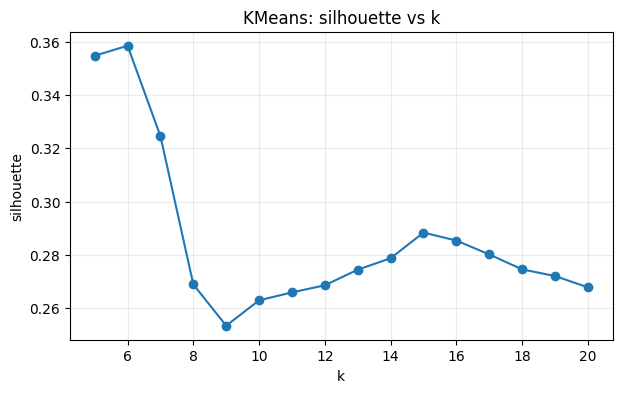

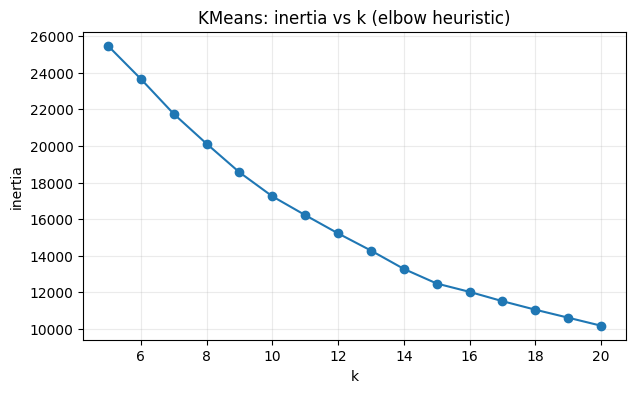

In [41]:
def eval_kmeans_grid(X_feat, ks):
    results = []
    for k in ks:
        model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = model.fit_predict(X_feat)
        metrics = safe_cluster_metrics(X_feat, labels)

        results.append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels,
            "metrics": metrics,
            "inertia": float(model.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0,
        })
    return results

kmeans_results1 = eval_kmeans_grid(X1_processed, kmeans_ks)

def eval_graf(kmeans_res, n = 1):
    ks = [r["params"]["k"] for r in kmeans_res]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_res]
    
    plt.figure(figsize=(7, 4))
    plt.plot(ks, sil, marker="o")
    plt.title("KMeans: silhouette vs k")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.grid(True, alpha=0.25)
    plt.savefig(f"artifacts/figures/kmeans_silhouette_dataset{n}.png", dpi=300)
    plt.show()
    
    # Инерция (elbow) – как эвристика
    inertia = [r["inertia"] for r in kmeans_res]
    plt.figure(figsize=(7, 4))
    plt.plot(ks, inertia, marker="o")
    plt.title("KMeans: inertia vs k (elbow heuristic)")
    plt.xlabel("k")
    plt.ylabel("inertia")
    plt.grid(True, alpha=0.25)
    plt.savefig(f"artifacts/figures/hmeans_inertia_dataset{n}.png", dpi=300)
    plt.show()

eval_graf(kmeans_results1, 1)

### Датасет 2

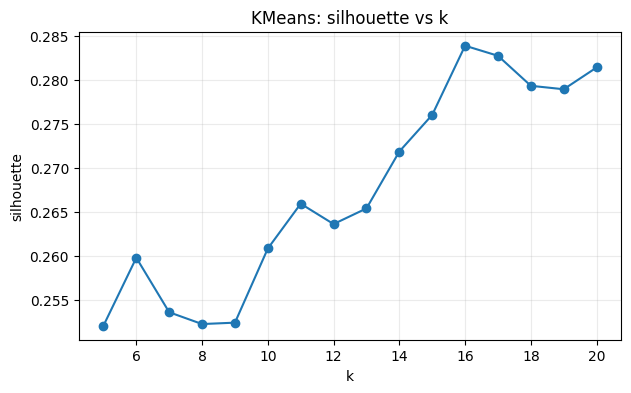

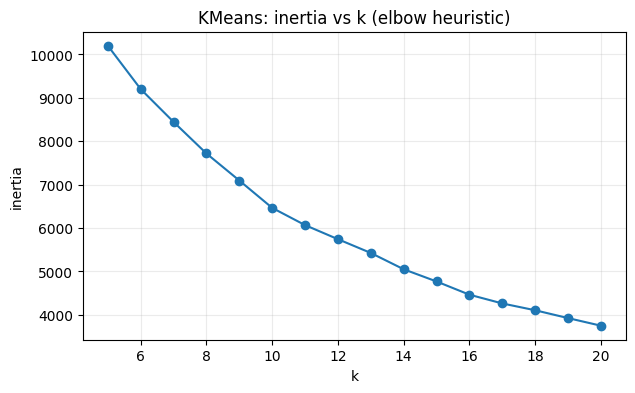

In [42]:
kmeans_results2 = eval_kmeans_grid(X2_processed, kmeans_ks)
eval_graf(kmeans_results2, 2)

### Датасет 3

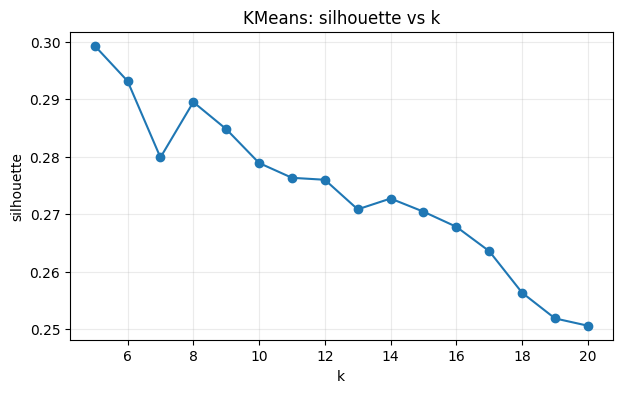

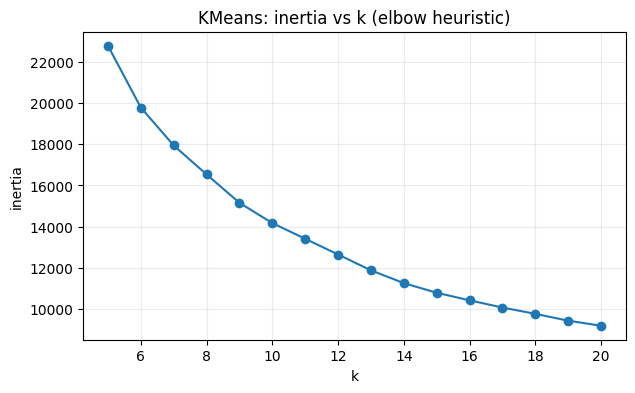

In [43]:
kmeans_results3 = eval_kmeans_grid(X3_processed, kmeans_ks)
eval_graf(kmeans_results3, 3)

### Датасет 4

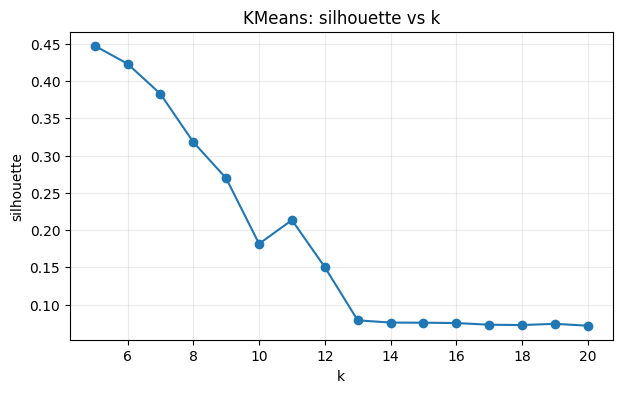

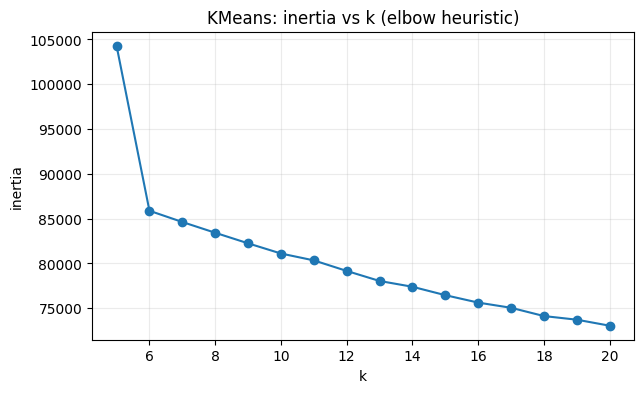

In [44]:
kmeans_results4 = eval_kmeans_grid(X4_processed, kmeans_ks)
eval_graf(kmeans_results4, 4)

## DBSCAN

### Датасет 1

In [45]:
def eval_dbscan_grid(X_feat, eps_list, min_samples_list):
    results = []
    n = len(X_feat)

    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X_feat)

            noise_frac = float(np.mean(labels == -1))
            # Метрики по non-noise
            mask = labels != -1
            labels_nn = labels[mask]
            X_nn = X_feat[mask]

            # Перенумеруем метки non-noise, чтобы метрики работали корректнее (не обязательно, но аккуратно)
            if len(labels_nn) > 0:
                uniq = np.unique(labels_nn)
                mapping = {u: i for i, u in enumerate(uniq)}
                labels_nn = np.array([mapping[v] for v in labels_nn], dtype=int)

            metrics = None
            n_clusters = 0
            if len(X_nn) >= 10 and len(np.unique(labels_nn)) >= 2:
                metrics = safe_cluster_metrics(X_nn, labels_nn)
                n_clusters = len(np.unique(labels_nn))

            results.append({
                "algo": "dbscan",
                "params": {"eps": float(eps), "min_samples": int(ms)},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": int(n_clusters),
                "noise_frac": float(noise_frac),
                "n_non_noise": int(mask.sum()),
            })
    return results

dbscan_results1 = eval_dbscan_grid(X1_processed, dbscan_eps, dbscan_min_samples)

def validation(dbscan_results):
    valid = [r for r in dbscan_results if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
    print("Valid DBSCAN configs:", len(valid))
    
    valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
    for r in valid_sorted[:8]:
        print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])
    return valid_sorted

valid_sort1 = validation(dbscan_results1)

Valid DBSCAN configs: 24
{'eps': 0.6, 'min_samples': 6} sil= 0.382 noise= 0.012 clusters= 5
{'eps': 0.6, 'min_samples': 5} sil= 0.382 noise= 0.011 clusters= 5
{'eps': 0.6, 'min_samples': 3} sil= 0.381 noise= 0.008 clusters= 5
{'eps': 0.75, 'min_samples': 6} sil= 0.379 noise= 0.003 clusters= 5
{'eps': 0.75, 'min_samples': 5} sil= 0.379 noise= 0.003 clusters= 5
{'eps': 0.75, 'min_samples': 4} sil= 0.379 noise= 0.002 clusters= 5
{'eps': 0.75, 'min_samples': 3} sil= 0.379 noise= 0.002 clusters= 5
{'eps': 0.6, 'min_samples': 4} sil= 0.312 noise= 0.009 clusters= 7


### Датасет 2

In [46]:
dbscan_eps2 = np.arange(0.2, 0.3, 0.01)
dbscan_results2 = eval_dbscan_grid(X2_processed, dbscan_eps2, dbscan_min_samples)
valid_sort2 = validation(dbscan_results2)

Valid DBSCAN configs: 40
{'eps': 0.26000000000000006, 'min_samples': 6} sil= 0.31 noise= 0.085 clusters= 2
{'eps': 0.2700000000000001, 'min_samples': 6} sil= 0.309 noise= 0.083 clusters= 2
{'eps': 0.2800000000000001, 'min_samples': 6} sil= 0.271 noise= 0.081 clusters= 2
{'eps': 0.25000000000000006, 'min_samples': 6} sil= 0.212 noise= 0.087 clusters= 2
{'eps': 0.2900000000000001, 'min_samples': 6} sil= 0.105 noise= 0.077 clusters= 4
{'eps': 0.26000000000000006, 'min_samples': 5} sil= 0.08 noise= 0.079 clusters= 6
{'eps': 0.23000000000000004, 'min_samples': 6} sil= 0.079 noise= 0.094 clusters= 5
{'eps': 0.22000000000000003, 'min_samples': 6} sil= 0.068 noise= 0.099 clusters= 4


### Датасет 3

In [47]:
dbscan_eps3 = np.arange(0.4, 0.6, 0.1)
dbscan_results3 = eval_dbscan_grid(X3_processed, dbscan_eps3, [2, 3, 5])
valid_sort3 = validation(dbscan_results3)

Valid DBSCAN configs: 6
{'eps': 0.4, 'min_samples': 5} sil= -0.04 noise= 0.05 clusters= 6
{'eps': 0.5, 'min_samples': 5} sil= -0.104 noise= 0.022 clusters= 4
{'eps': 0.5, 'min_samples': 3} sil= -0.232 noise= 0.016 clusters= 12
{'eps': 0.4, 'min_samples': 3} sil= -0.389 noise= 0.035 clusters= 31
{'eps': 0.5, 'min_samples': 2} sil= -0.395 noise= 0.012 clusters= 42
{'eps': 0.4, 'min_samples': 2} sil= -0.484 noise= 0.028 clusters= 83


### Датасет 4

In [48]:
dbscan_eps4 = np.arange(2, 3.5, 0.5)
dbscan_results4 = eval_dbscan_grid(X4_processed, dbscan_eps4, dbscan_min_samples)
valid_sort4 = validation(dbscan_results4)

Valid DBSCAN configs: 12
{'eps': 2.5, 'min_samples': 6} sil= 0.443 noise= 0.091 clusters= 6
{'eps': 2.5, 'min_samples': 5} sil= 0.442 noise= 0.088 clusters= 6
{'eps': 3.0, 'min_samples': 5} sil= 0.426 noise= 0.009 clusters= 6
{'eps': 3.0, 'min_samples': 6} sil= 0.426 noise= 0.009 clusters= 6
{'eps': 3.0, 'min_samples': 3} sil= 0.425 noise= 0.008 clusters= 6
{'eps': 3.0, 'min_samples': 4} sil= 0.425 noise= 0.008 clusters= 6
{'eps': 2.5, 'min_samples': 4} sil= 0.384 noise= 0.085 clusters= 7
{'eps': 2.5, 'min_samples': 3} sil= 0.381 noise= 0.082 clusters= 8


## AgglomerativeClustering

### Датасет 1

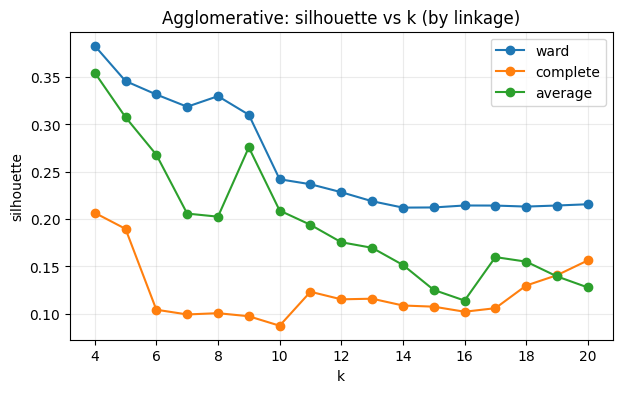

In [49]:
def eval_agglomerative_grid(X_feat, ks, linkages):
    results = []
    for linkage_name in linkages:
        for k in ks:
            try:
                model = AgglomerativeClustering(n_clusters=k, linkage=linkage_name)
                labels = model.fit_predict(X_feat)
            except Exception:
                continue

            metrics = safe_cluster_metrics(X_feat, labels)

            results.append({
                "algo": "agglomerative",
                "params": {"k": int(k), "linkage": linkage_name},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": len(np.unique(labels)),
                "noise_frac": 0.0,
            })
    return results

agg_results1 = eval_agglomerative_grid(X1_processed, agg_ks, agg_linkages)

def eval_graf_agg(agg_results, n = 1):
    plt.figure(figsize=(7, 4))
    
    for linkage_name in agg_linkages:
        subset = [r for r in agg_results if r["params"]["linkage"] == linkage_name]
        subset = sorted(subset, key=lambda r: r["params"]["k"])
        ks = [r["params"]["k"] for r in subset]
        sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in subset]
        plt.plot(ks, sil, marker="o", label=linkage_name)
    
    plt.title("Agglomerative: silhouette vs k (by linkage)")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.savefig(f"artifacts/figures/agg_silhouette_dataset{n}.png", dpi=300)
    plt.show()

eval_graf_agg(agg_results1, 1)

### Датасет 2

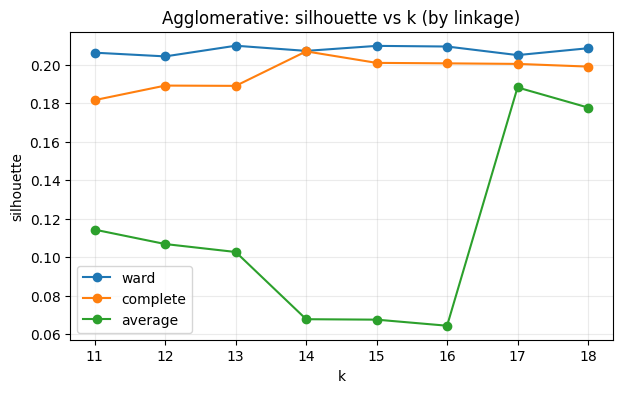

In [50]:
agg_results2 = eval_agglomerative_grid(X2_processed, list(range(11, 19)), agg_linkages)
eval_graf_agg(agg_results2, 2)

### Датасет 3

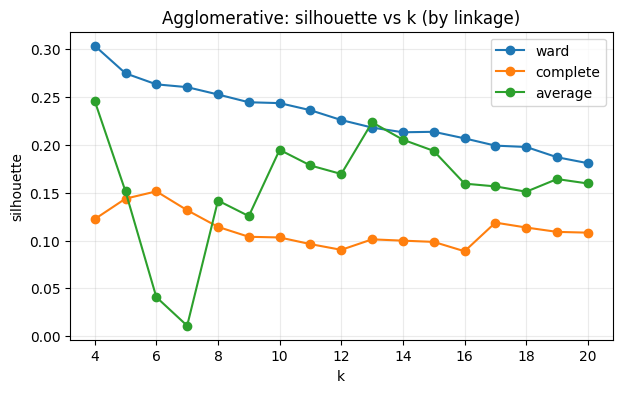

In [51]:
agg_results3 = eval_agglomerative_grid(X3_processed, agg_ks, agg_linkages)
eval_graf_agg(agg_results3, 3)

### Датасет 4

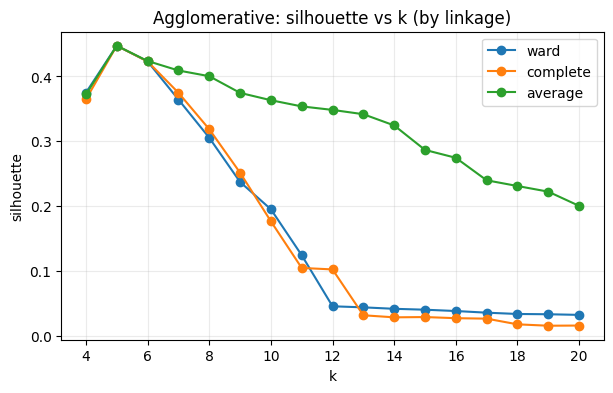

In [52]:
agg_results4 = eval_agglomerative_grid(X4_processed, agg_ks, agg_linkages)
eval_graf_agg(agg_results4, 4)

# Метрики качества

### Вспомогательные функции

In [53]:
def pick_best_by_silhouette(results):
    best = None
    best_score = -np.inf
    for r in results:
        m = r["metrics"]
        if m is None:
            continue
        s = m["silhouette"]
        if s is None:
            continue
        if s > best_score:
            best_score = s
            best = r
    return best, best_score

def print_result_card(name, result):
    m = result["metrics"] or {}
    print("=" * 72)
    print(f"{name}")
    print("algo:", result["algo"])
    print("params:", result["params"])
    print("n_clusters:", result.get("n_clusters"))
    if result["algo"] == "dbscan":
        print("noise_frac:", round(result.get("noise_frac", 0.0), 3), " non-noise:", result.get("n_non_noise"))
    print("metrics:")
    print("  silhouette_score:", None if m.get("silhouette") is None else round(m["silhouette"], 3))
    print("  davies_bouldin_score:", None if m.get("davies_bouldin") is None else round(m["davies_bouldin"], 3))
    print("  calinski_harabasz_score:", None if m.get("calinski_harabasz") is None else round(m["calinski_harabasz"], 1))
    if result.get("inertia") is not None:
        print("  inertia:", round(result["inertia"], 1))


### Датасет 1

In [54]:
best_kmeans1, best_kmeans_s1 = pick_best_by_silhouette(kmeans_results1)
best_kmeans1["params"], round(best_kmeans_s1, 3)

best_agg1, best_agg_s1 = pick_best_by_silhouette(agg_results1)
best_agg1["params"], round(best_agg_s1, 3)

best_dbscan1 = valid_sort1[0] if valid_sort1 else None
best_dbscan1["params"] if best_dbscan1 else "No valid confi||g found"

print_result_card("BEST KMEANS (by silhouette)", best_kmeans1)
if best_dbscan1 is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan1)
print_result_card("BEST AGGLOMERATIVE (by silhouette)", best_agg1)

BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 6}
n_clusters: 6
metrics:
  silhouette_score: 0.359
  davies_bouldin_score: 1.182
  calinski_harabasz_score: 7333.4
  inertia: 23662.2
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 0.6, 'min_samples': 6}
n_clusters: 5
noise_frac: 0.012  non-noise: 11851
metrics:
  silhouette_score: 0.382
  davies_bouldin_score: 1.25
  calinski_harabasz_score: 8456.1
BEST AGGLOMERATIVE (by silhouette)
algo: agglomerative
params: {'k': 4, 'linkage': 'ward'}
n_clusters: 4
metrics:
  silhouette_score: 0.383
  davies_bouldin_score: 1.16
  calinski_harabasz_score: 9425.8


### Датасет 2

In [55]:
best_kmeans2, best_kmeans_s2 = pick_best_by_silhouette(kmeans_results2)
best_kmeans2["params"], round(best_kmeans_s2, 3)

best_dbscan2 = valid_sort2[0] if valid_sort2 else None
best_dbscan2["params"] if best_dbscan2 else "No valid config found"

best_agg2, best_agg_s2 = pick_best_by_silhouette(agg_results2)
best_agg2["params"], round(best_agg_s2, 3)

print_result_card("BEST KMEANS (by silhouette)", best_kmeans2)
if best_dbscan2 is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan2)
print_result_card("BEST AGGLOMERATIVE (by silhouette)", best_agg2)

BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 16}
n_clusters: 16
metrics:
  silhouette_score: 0.284
  davies_bouldin_score: 0.956
  calinski_harabasz_score: 2329.4
  inertia: 4463.9
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 0.26000000000000006, 'min_samples': 6}
n_clusters: 2
noise_frac: 0.085  non-noise: 7323
metrics:
  silhouette_score: 0.31
  davies_bouldin_score: 0.575
  calinski_harabasz_score: 20.6
BEST AGGLOMERATIVE (by silhouette)
algo: agglomerative
params: {'k': 13, 'linkage': 'ward'}
n_clusters: 13
metrics:
  silhouette_score: 0.21
  davies_bouldin_score: 1.172
  calinski_harabasz_score: 1802.9


### Датасет 3

In [56]:
best_kmeans3, best_kmeans_s3 = pick_best_by_silhouette(kmeans_results3)
best_kmeans3["params"], round(best_kmeans_s3, 3)

best_dbscan3 = valid_sort3[0] if valid_sort3 else None
best_dbscan3["params"] if best_dbscan3 else "No valid config found"


best_agg3, best_agg_s3 = pick_best_by_silhouette(agg_results3)
best_agg3["params"], round(best_agg_s3, 3)

print_result_card("BEST KMEANS (by silhouette)", best_kmeans3)
if best_dbscan3 is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan3)
print_result_card("BEST AGGLOMERATIVE (by silhouette)", best_agg3)

BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 5}
n_clusters: 5
metrics:
  silhouette_score: 0.299
  davies_bouldin_score: 1.169
  calinski_harabasz_score: 6125.1
  inertia: 22779.9
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 0.4, 'min_samples': 5}
n_clusters: 6
noise_frac: 0.05  non-noise: 14257
metrics:
  silhouette_score: -0.04
  davies_bouldin_score: 1.01
  calinski_harabasz_score: 1256.3
BEST AGGLOMERATIVE (by silhouette)
algo: agglomerative
params: {'k': 4, 'linkage': 'ward'}
n_clusters: 4
metrics:
  silhouette_score: 0.304
  davies_bouldin_score: 1.173
  calinski_harabasz_score: 6206.4


### Датасет 4

In [57]:
best_kmeans4, best_kmeans_s4 = pick_best_by_silhouette(kmeans_results4)
best_kmeans4["params"], round(best_kmeans_s4, 3)

best_dbscan4 = valid_sort4[0] if valid_sort4 else None
best_dbscan4["params"] if best_dbscan4 else "No valid config found"

best_agg4, best_agg_s4 = pick_best_by_silhouette(agg_results4)
best_agg4["params"], round(best_agg_s4, 3)

print_result_card("BEST KMEANS (by silhouette)", best_kmeans4)
if best_dbscan4 is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan4)
print_result_card("BEST AGGLOMERATIVE (by silhouette)", best_agg4)

BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 5}
n_clusters: 5
metrics:
  silhouette_score: 0.447
  davies_bouldin_score: 0.976
  calinski_harabasz_score: 5087.7
  inertia: 104300.6
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 2.5, 'min_samples': 6}
n_clusters: 6
noise_frac: 0.091  non-noise: 9086
metrics:
  silhouette_score: 0.443
  davies_bouldin_score: 0.971
  calinski_harabasz_score: 5329.5
BEST AGGLOMERATIVE (by silhouette)
algo: agglomerative
params: {'k': 5, 'linkage': 'ward'}
n_clusters: 5
metrics:
  silhouette_score: 0.447
  davies_bouldin_score: 0.976
  calinski_harabasz_score: 5087.7


# Визуализация

### Датасет 1

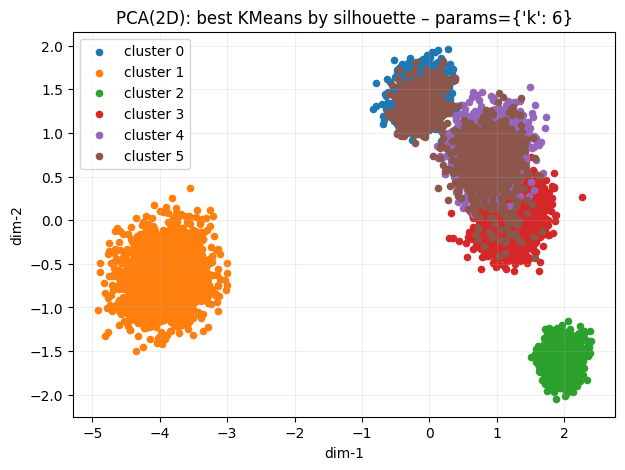

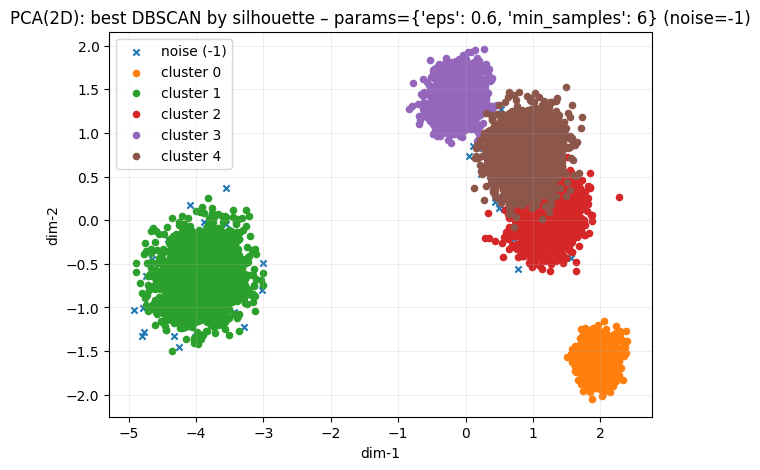

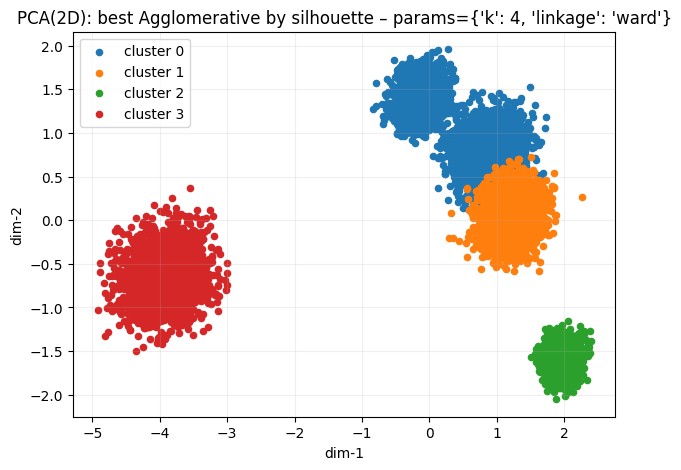

In [58]:
X_plot2d = pca_2d_for_plot(X1_processed, random_state=RANDOM_STATE)

plot_2d_embedding(
    X_plot2d, best_kmeans1["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans1['params']}",
    name_algo = "kmeans",
    n = 1
)

# DBSCAN best (if exists)
if best_dbscan1 is not None:
    plot_2d_embedding(
        X_plot2d, best_dbscan1["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan1['params']} (noise=-1)",
        name_algo = "dbscan",
        n = 1
    )

# Agglomerative best
plot_2d_embedding(
    X_plot2d, best_agg1["labels"],
    title=f"PCA(2D): best Agglomerative by silhouette – params={best_agg1['params']}",
    name_algo = "agg",
    n = 1
)


### Датасет 2

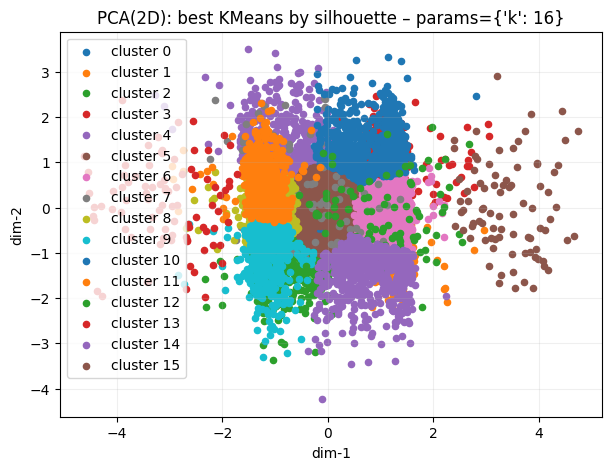

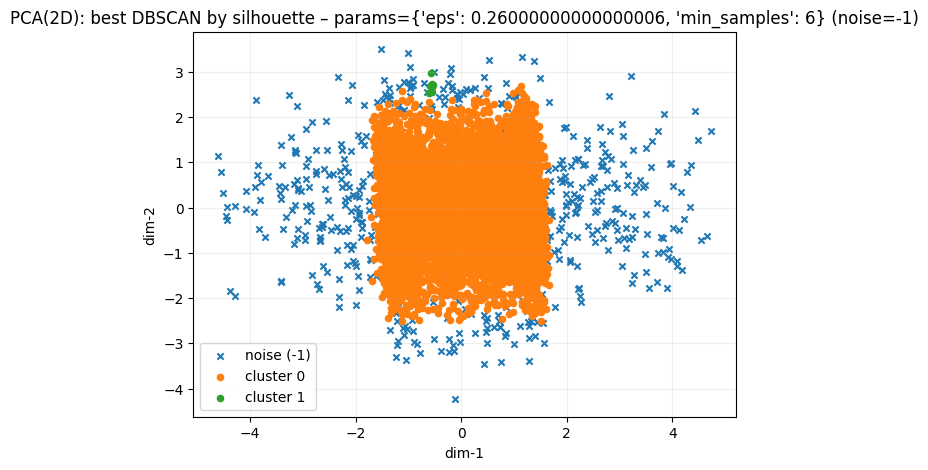

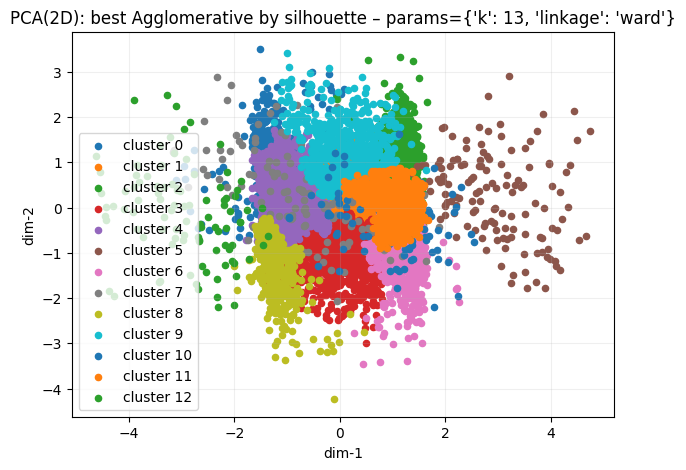

In [59]:
X_plot2d = pca_2d_for_plot(X2_processed, random_state=RANDOM_STATE)

plot_2d_embedding(
    X_plot2d, best_kmeans2["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans2['params']}",
    name_algo = "kmeans",
    n = 2
)

# DBSCAN best (if exists)
if best_dbscan2 is not None:
    plot_2d_embedding(
        X_plot2d, best_dbscan2["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan2['params']} (noise=-1)",
        name_algo = "dbscan",
        n = 2
    )

# Agglomerative best
plot_2d_embedding(
    X_plot2d, best_agg2["labels"],
    title=f"PCA(2D): best Agglomerative by silhouette – params={best_agg2['params']}",
    name_algo = "agg",
    n = 2
)


### Датасет 3

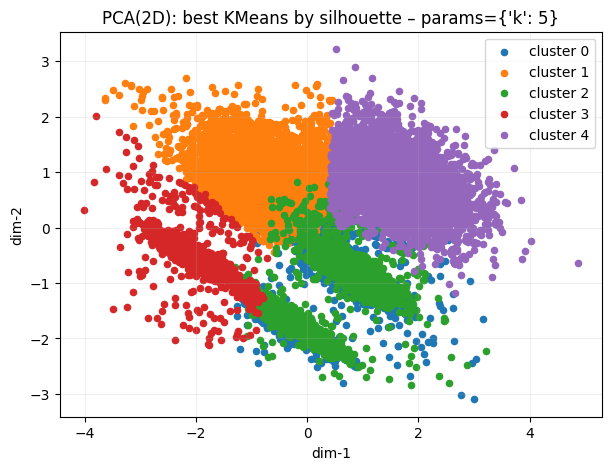

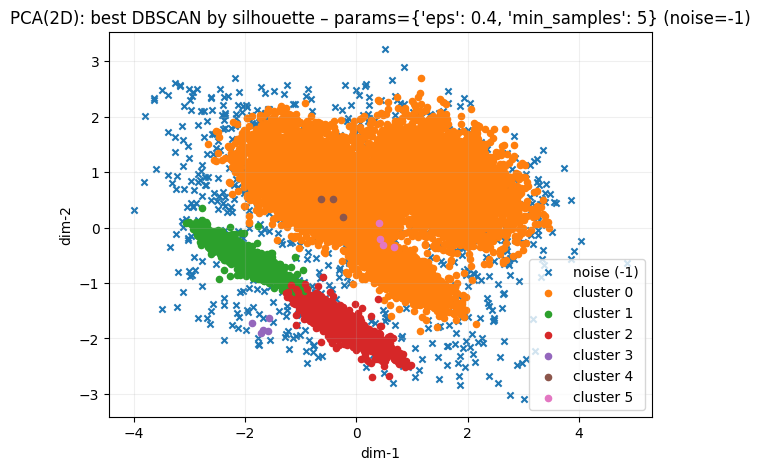

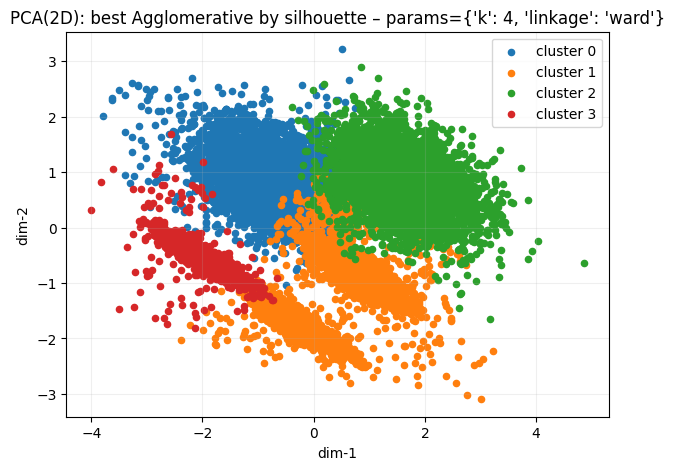

In [60]:
X_plot2d = pca_2d_for_plot(X3_processed, random_state=RANDOM_STATE)

plot_2d_embedding(
    X_plot2d, best_kmeans3["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans3['params']}",
    name_algo = "kmeans",
    n = 3
)

# DBSCAN best (if exists)
if best_dbscan3 is not None:
    plot_2d_embedding(
        X_plot2d, best_dbscan3["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan3['params']} (noise=-1)",
        name_algo = "dbscan",
        n = 3
    )

# Agglomerative best
plot_2d_embedding(
    X_plot2d, best_agg3["labels"],
    title=f"PCA(2D): best Agglomerative by silhouette – params={best_agg3['params']}",
    name_algo = "agg",
    n = 3
)


### Датасет 4

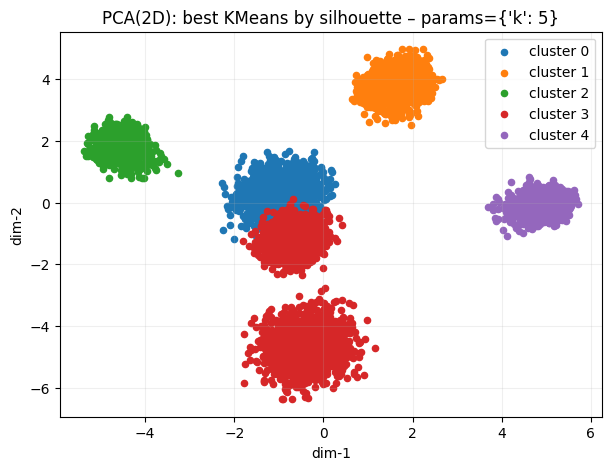

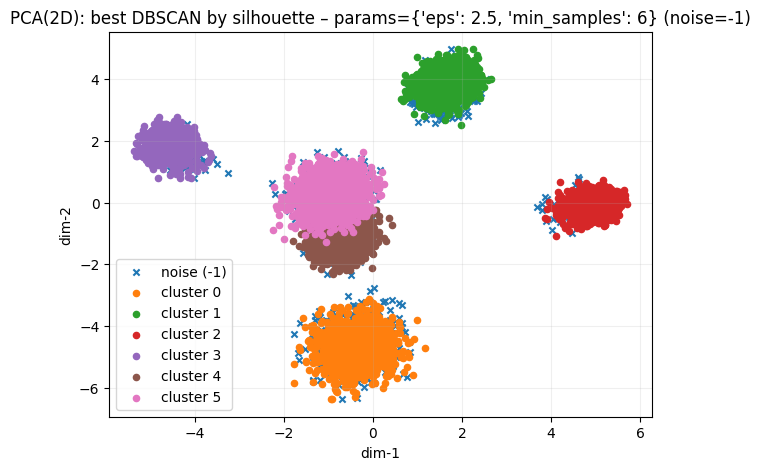

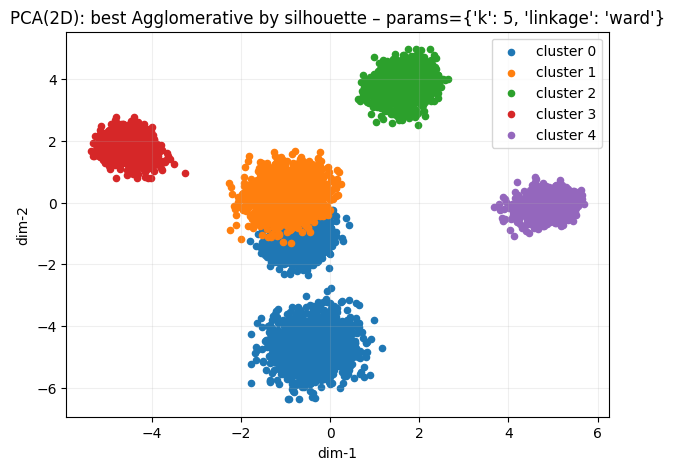

In [61]:
X_plot2d = pca_2d_for_plot(X4_processed, random_state=RANDOM_STATE)

plot_2d_embedding(
    X_plot2d, best_kmeans4["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans4['params']}",
    name_algo = "kmeans",
    n = 4
)

# DBSCAN best (if exists)
if best_dbscan4 is not None:
    plot_2d_embedding(
        X_plot2d, best_dbscan4["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan4['params']} (noise=-1)",
        name_algo = "dbscan",
        n = 4
    )

# Agglomerative best
plot_2d_embedding(
    X_plot2d, best_agg4["labels"],
    title=f"PCA(2D): best Agglomerative by silhouette – params={best_agg4['params']}",
    name_algo = "agg",
    n = 4
)


In [62]:
X_plot2d

array([[-1.06538797,  0.08453897],
       [-0.31695844, -4.67698485],
       [ 2.19605863,  4.16469924],
       ...,
       [-4.66464687,  1.86438847],
       [ 5.08992379, -0.05131275],
       [ 4.98155523,  0.1919074 ]], shape=(10000, 2))

# Устойчивость (kmeans)

### Датасет 1

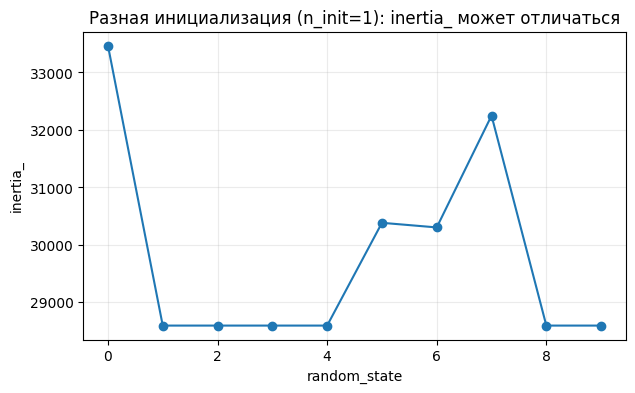

min inertia: 28591.33
max inertia: 33466.85
Средний попарный ARI: 1.000
Средний попарный NMI: 1.000


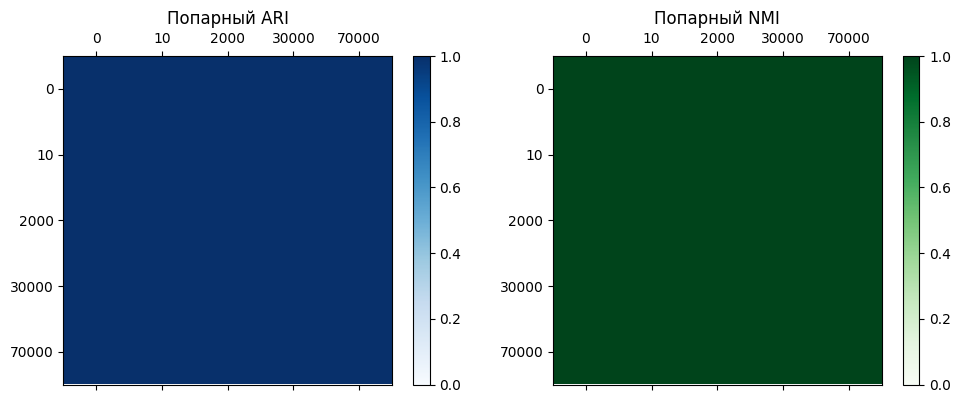

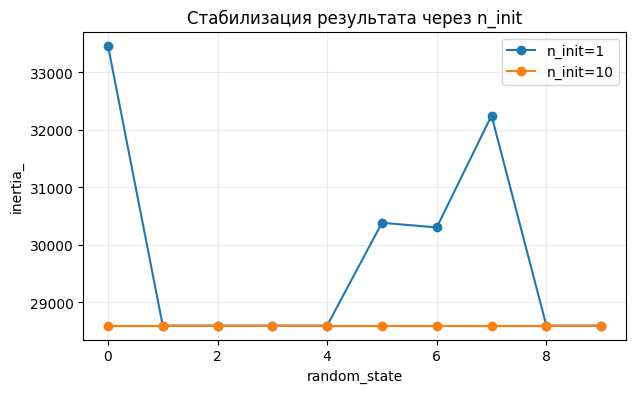

In [63]:
inertias = []
states = list(range(10))

for rs in states:
    m = KMeans(n_clusters=4, n_init=1, random_state=rs)
    m.fit(X1_processed)
    inertias.append(m.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(states, inertias, marker="o")
plt.title("Разная инициализация (n_init=1): inertia_ может отличаться")
plt.xlabel("random_state")
plt.ylabel("inertia_")
plt.grid(True, alpha=0.25)
plt.savefig(f"artifacts/figures/stability_before_dataset1.png", dpi=300)
plt.show()

print("min inertia:", round(float(np.min(inertias)), 2))
print("max inertia:", round(float(np.max(inertias)), 2))
print("=" * 72)



inertias_1 = []
inertias_10 = []
labels_list = []
RANDOM_STATES = [0, 10, 2000, 30000, 70000]
for rs in RANDOM_STATES:
    kmeans = KMeans(n_clusters=4, n_init=10, random_state=rs)
    labels = kmeans.fit_predict(X1_processed)
    labels_list.append(labels)

# Считаем попарные ARI и NMI
ari_matrix = np.zeros((len(RANDOM_STATES), len(RANDOM_STATES)))
nmi_matrix = np.zeros((len(RANDOM_STATES), len(RANDOM_STATES)))

for i in range(len(labels_list)):
    for j in range(len(labels_list)):
        if i == j:
            ari_matrix[i, j] = 1.0
            nmi_matrix[i, j] = 1.0
        else:
            ari_matrix[i, j] = adjusted_rand_score(labels_list[i], labels_list[j])
            nmi_matrix[i, j] = normalized_mutual_info_score(labels_list[i], labels_list[j])


def mean_off_diagonal(mat):
    mask = ~np.eye(mat.shape[0], dtype=bool)
    return np.mean(mat[mask])

mean_ari = mean_off_diagonal(ari_matrix)
mean_nmi = mean_off_diagonal(nmi_matrix)

print(f"Средний попарный ARI: {mean_ari:.3f}")
print(f"Средний попарный NMI: {mean_nmi:.3f}")

# Опционально: визуализация матриц
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
im1 = axes[0].matshow(ari_matrix, vmin=0, vmax=1, cmap='Blues')
axes[0].set_title("Попарный ARI")
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].matshow(nmi_matrix, vmin=0, vmax=1, cmap='Greens')
axes[1].set_title("Попарный NMI")
plt.colorbar(im2, ax=axes[1])

for ax in axes:
    ax.set_xticks(range(len(RANDOM_STATES)))
    ax.set_yticks(range(len(RANDOM_STATES)))
    ax.set_xticklabels(RANDOM_STATES)
    ax.set_yticklabels(RANDOM_STATES)

plt.tight_layout()
plt.savefig("artifacts/figures/stability_ari_nmi_dataset1.png", dpi=300)
plt.show()

for rs in states:
    m1 = KMeans(n_clusters=4, n_init=1, random_state=rs)
    m1.fit(X1_processed)
    inertias_1.append(m1.inertia_)

    m10 = KMeans(n_clusters=4, n_init=10, random_state=rs)
    m10.fit(X1_processed)
    inertias_10.append(m10.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(states, inertias_1, marker="o", label="n_init=1")
plt.plot(states, inertias_10, marker="o", label="n_init=10")
plt.title("Стабилизация результата через n_init")
plt.xlabel("random_state")
plt.ylabel("inertia_")
plt.grid(True, alpha=0.25)
plt.legend()
plt.savefig(f"artifacts/figures/stability_after_dataset1.png", dpi=300)
plt.show()


### Датасет 2

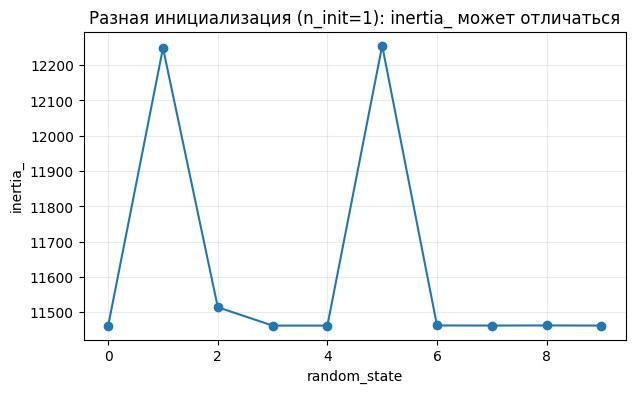

min inertia: 11462.17
max inertia: 12255.28


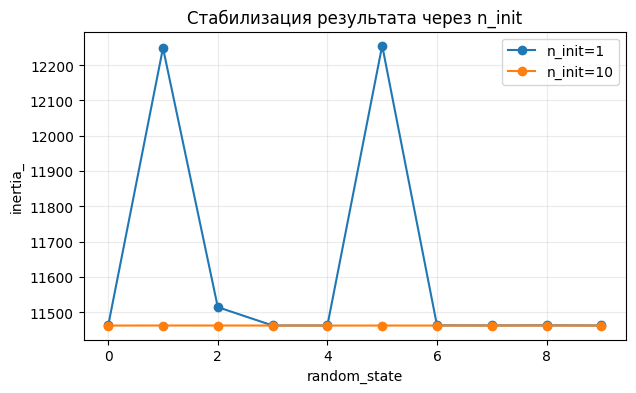

In [64]:
inertias = []
states = list(range(10))

for rs in states:
    m = KMeans(n_clusters=4, n_init=1, random_state=rs)
    m.fit(X2_processed)
    inertias.append(m.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(states, inertias, marker="o")
plt.title("Разная инициализация (n_init=1): inertia_ может отличаться")
plt.xlabel("random_state")
plt.ylabel("inertia_")
plt.grid(True, alpha=0.25)
plt.savefig(f"artifacts/figures/stability_before_dataset2.png", dpi=300)
plt.show()

print("min inertia:", round(float(np.min(inertias)), 2))
print("max inertia:", round(float(np.max(inertias)), 2))
 
inertias_1 = []
inertias_10 = []

for rs in states:
    m1 = KMeans(n_clusters=4, n_init=1, random_state=rs)
    m1.fit(X2_processed)
    inertias_1.append(m1.inertia_)

    m10 = KMeans(n_clusters=4, n_init=10, random_state=rs)
    m10.fit(X2_processed)
    inertias_10.append(m10.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(states, inertias_1, marker="o", label="n_init=1")
plt.plot(states, inertias_10, marker="o", label="n_init=10")
plt.title("Стабилизация результата через n_init")
plt.xlabel("random_state")
plt.ylabel("inertia_")
plt.grid(True, alpha=0.25)
plt.legend()
plt.savefig(f"artifacts/figures/stability_after_dataset2.png", dpi=300)
plt.show()

### Датасет 3

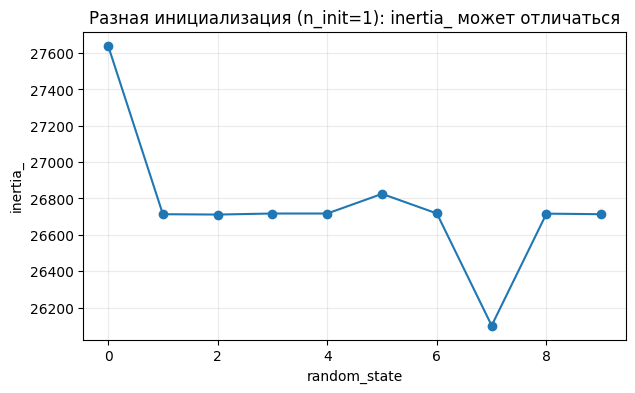

min inertia: 26100.57
max inertia: 27641.42


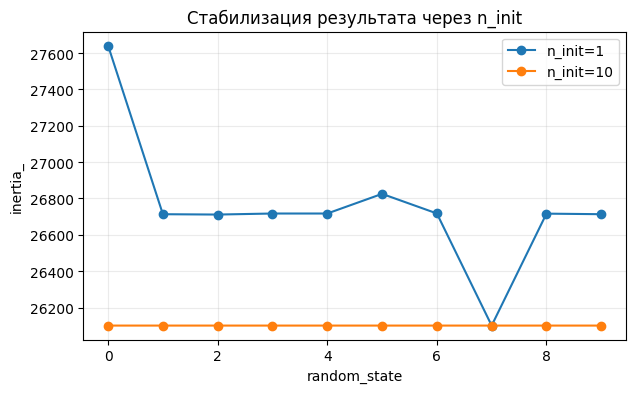

In [65]:
inertias = []
states = list(range(10))

for rs in states:
    m = KMeans(n_clusters=4, n_init=1, random_state=rs)
    m.fit(X3_processed)
    inertias.append(m.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(states, inertias, marker="o")
plt.title("Разная инициализация (n_init=1): inertia_ может отличаться")
plt.xlabel("random_state")
plt.ylabel("inertia_")
plt.grid(True, alpha=0.25)
plt.savefig(f"artifacts/figures/stability_before_dataset3.png", dpi=300)
plt.show()

print("min inertia:", round(float(np.min(inertias)), 2))
print("max inertia:", round(float(np.max(inertias)), 2))
 
inertias_1 = []
inertias_10 = []

for rs in states:
    m1 = KMeans(n_clusters=4, n_init=1, random_state=rs)
    m1.fit(X3_processed)
    inertias_1.append(m1.inertia_)

    m10 = KMeans(n_clusters=4, n_init=10, random_state=rs)
    m10.fit(X3_processed)
    inertias_10.append(m10.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(states, inertias_1, marker="o", label="n_init=1")
plt.plot(states, inertias_10, marker="o", label="n_init=10")
plt.title("Стабилизация результата через n_init")
plt.xlabel("random_state")
plt.ylabel("inertia_")
plt.grid(True, alpha=0.25)
plt.legend()
plt.savefig(f"artifacts/figures/stability_after_dataset3.png", dpi=300)
plt.show()


### Датасет 4

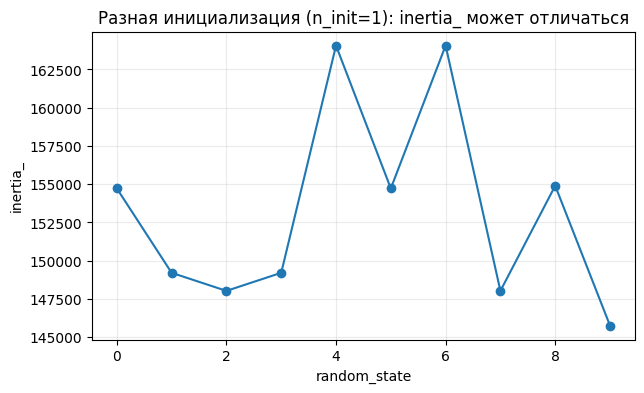

min inertia: 145756.15
max inertia: 164063.34


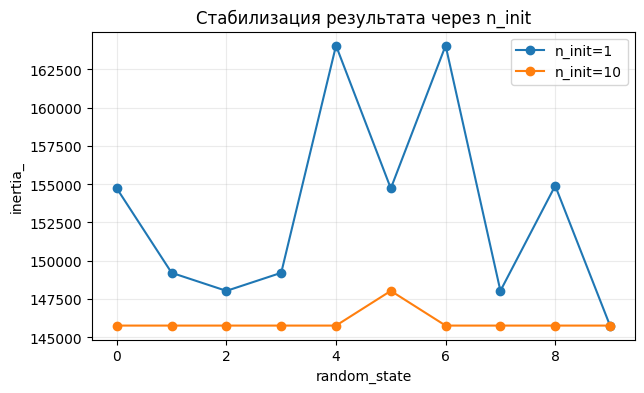

In [66]:
inertias = []
states = list(range(10))

for rs in states:
    m = KMeans(n_clusters=4, n_init=1, random_state=rs)
    m.fit(X4_processed)
    inertias.append(m.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(states, inertias, marker="o")
plt.title("Разная инициализация (n_init=1): inertia_ может отличаться")
plt.xlabel("random_state")
plt.ylabel("inertia_")
plt.grid(True, alpha=0.25)
plt.savefig(f"artifacts/figures/stability_before_dataset4.png", dpi=300)
plt.show()

print("min inertia:", round(float(np.min(inertias)), 2))
print("max inertia:", round(float(np.max(inertias)), 2))
 
inertias_1 = []
inertias_10 = []

for rs in states:
    m1 = KMeans(n_clusters=4, n_init=1, random_state=rs)
    m1.fit(X4_processed)
    inertias_1.append(m1.inertia_)

    m10 = KMeans(n_clusters=4, n_init=10, random_state=rs)
    m10.fit(X4_processed)
    inertias_10.append(m10.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(states, inertias_1, marker="o", label="n_init=1")
plt.plot(states, inertias_10, marker="o", label="n_init=10")
plt.title("Стабилизация результата через n_init")
plt.xlabel("random_state")
plt.ylabel("inertia_")
plt.grid(True, alpha=0.25)
plt.legend()
plt.savefig(f"artifacts/figures/stability_after_dataset4.png", dpi=300)
plt.show()


# Итог по каждому датасету

### Датасет 1

Лучший метод: DBSCAN (eps = 0.6, min_samples = 6)

Подобранные параметры (eps=0.6, min_samples=6) позволили выделить компактные, плотные группы без маркировки большого числа точек как выбросов. Визуализация в PCA-пространстве подтвердила чёткость полученных кластеров. Таким образом, DBSCAN лучше отразил истинную структуру данных, не навязывая сферическую форму кластерам, как это делает KMeans.

BEST DBSCAN (by silhouette among valid)
- algo: dbscan
- params: {'eps': 0.6, 'min_samples': 6}
- n_clusters: 5
- noise_frac: 0.012  non-noise: 11851
- metrics:
  - silhouette_score: 0.382
  - davies_bouldin_score: 1.25
  - calinski_harabasz_score: 8456.1

### Датасет 2

Лучший метод: KMeans (k=16) 

Несмотря на нелинейную структуру и выбросы, KMeans с k=16 достиг silhouette_score (0.284). DBSCAN выделил значительную долю точек как шум (8–9%), а Agglomerative дал разбиение хуже, чем Kmeans. Выбор KMeans мотивирован тем, что даже при неидеальных условиях он обеспечивает воспроизводимость и покрывает большую часть данных без маркировки как выбросов.

Присутствует явный шумовой признак (z_noise) и нелинейная форма кластеров. Это снижает эффективность KMeans, но другие методы оказались ещё менее надёжными: DBSCAN слишком чувствителен к выбросам, а Agglomerative — к высокой гранулярности. Увеличение k позволило KMeans аппроксимировать сложную форму через множество мелких кластеров.

Agglomerative имеет не очень красивое очертание данных на графике, но его стоит учитывать на роль "лучший метод"

BEST KMEANS (by silhouette)
- algo: kmeans
- params: {'k': 16}
- n_clusters: 16
- metrics:
  - silhouette_score: 0.284
  - davies_bouldin_score: 0.956
  - calinski_harabasz_score: 2329.4
  - inertia: 4463.9


BEST AGGLOMERATIVE (by silhouette)
- algo: agglomerative
- params: {'k': 13, 'linkage': 'ward'}
- n_clusters: 13
- metrics:
  - silhouette_score: 0.21
  - davies_bouldin_score: 1.172
  -c alinski_harabasz_score: 1802.9

### Датасет 3

Лучший метод: Agglomerative Clustering (k = 4, linkage = 'ward')

Данный датасет характеризуется кластерами разной плотности и наличием фонового шума, что создаёт сложности для методов, чувствительных к равномерности распределения (например, KMeans). Хотя KMeans с тем же числом кластеров (k=4) показал сопоставимый silhouette_score и визуально похожее разбиение, Agglomerative с ward-связью был выбран как более надёжный, поскольку он не зависит от случайной инициализации и детерминированно минимизирует внутрикластерную дисперсию — это особенно важно при наличии шума. Кроме того, иерархический подход лучше справляется с небольшими вариациями плотности, не разбивая компактные группы искусственно. Препроцессинг (масштабирование и импутация) обеспечил корректную работу обоих методов, но Agglomerative предоставил более стабильное и интерпретируемое решение без риска застревания в локальных минимумах.

BEST AGGLOMERATIVE (by silhouette)
- algo: agglomerative
- params: {'k': 4, 'linkage': 'ward'}
- n_clusters: 4
- metrics:
  - silhouette_score: 0.304
  - davies_bouldin_score: 1.173
  - calinski_harabasz_score: 6206.4

### Датасет 4

Лучший метод: DBSCAN (eps = 2.5, min_samples = 6)

Датасет содержит высокую размерность, два категориальных признака и пропуски в числовых переменных. После аккуратного препроцессинга (SimpleImputer для пропусков, OneHotEncoder для категориальных признаков, StandardScaler для числовых) данные стали пригодны для кластеризации. Несмотря на то, что KMeans и Agglomerative показали умеренные значения silhouette_score (~0.45). DBSCAN с параметрами eps=2.5, min_samples=6 выделил компактные, содержательные кластеры без маркировки значительной части данных как шума (в отличие от других попыток с меньшим eps). Высокое значение eps оправдано расширенным масштабом признакового пространства после кодирования. Метод оказался особенно уместен, так как позволил обнаружить естественные плотностные группы, не навязывая структуру и избегая артефактов, связанных с фиксированным числом кластеров.

BEST DBSCAN (by silhouette among valid)
- algo: dbscan
- params: {'eps': 2.5, 'min_samples': 6}
- n_clusters: 6
- noise_frac: 0.091  non-noise: 9086
- metrics:
  - silhouette_score: 0.443
  - davies_bouldin_score: 0.971
  - calinski_harabasz_score: 5329.5


# Артефакты эксперимента

metrics_summary.json – сводка метрик по датасетам и моделям (silhouette/DB/CH + доля шума для DBSCAN);

best_configs.json – какие параметры выбраны как "лучшие" для каждого датасета (и каким критерием);

labels/ – CSV-файлы с присвоенными кластерами для лучшего решения на каждом датасете, например:
- labels_ hw07_ds1.csv, labels_hw07_ds2.csv, ... Формат: sample_id,cluster_label (для DBSCAN кластер -1 допустим);


In [67]:
metrics_summary = {
    "S07-hw-dataset-01": {
        "algo": {
            "Kmeans": {
                "params": 6,
                "n_clusters:": 6,
                "metrics": {
                    "silhouette_score": 0.359,
                    "davies_bouldin_score": 1.182,
                    "calinski_harabasz_score": 7333.4,
                    "inertia": 23662.2
                }
            },
            "DBSCAN": {
                "params": {
                    "eps": 0.6,
                    "min_samples": 6,
                },
                "n_clusters:": 5,
                "noise_frac": 0.012,
                "non-noise": 11851,
                "metrics": {
                    "silhouette_score": 0.382,
                    "davies_bouldin_score": 1.25,
                    "calinski_harabasz_score": 8456.1,
                }
            },
             "Agglomerative": {
                "params": {
                    "k": 4,
                    "linkage": "ward",
                },
                "n_clusters:": 4,
                "metrics": {
                    "silhouette_score": 0.383,
                    "davies_bouldin_score": 1.16,
                    "calinski_harabasz_score": 9425.8,
                }
             }
        }
    },
    "S07-hw-dataset-02": {
       "algo": {
            "Kmeans": {
                "params": 16,
                "n_clusters:": 16,
                "metrics": {
                    "silhouette_score": 0.284,
                    "davies_bouldin_score": 0.956,
                    "calinski_harabasz_score": 2329.4,
                    "inertia": 4463.9
                }
            },
            "DBSCAN": {
                "params": {
                    "eps": 0.26,
                    "min_samples": 6,
                },
                "n_clusters:": 2,
                "noise_frac": 0.085,
                "non-noise": 7323,
                "metrics": {
                    "silhouette_score": 0.31,
                    "davies_bouldin_score": 0.575,
                    "calinski_harabasz_score": 20.6,
                }
            },
             "Agglomerative": {
                "params": {
                    "k": 13,
                    "linkage": "ward",
                },
                "n_clusters:": 13,
                "metrics": {
                    "silhouette_score": 0.21,
                    "davies_bouldin_score": 1.172,
                    "calinski_harabasz_score": 1802.9,
                }
             }
        } 
    },
    "S07-hw-dataset-03": {
        "algo": {
            "Kmeans": {
                "params": 5,
                "n_clusters:": 5,
                "metrics": {
                    "silhouette_score": 0.299,
                    "davies_bouldin_score": 1.169,
                    "calinski_harabasz_score": 6125.1,
                    "inertia": 22779.9
                }
            },
            "DBSCAN": {
                "params": {
                    "eps": 0.4,
                    "min_samples": 5,
                },
                "n_clusters:": 6,
                "noise_frac": 0.05,
                "non-noise": 14257,
                "metrics": {
                    "silhouette_score": -0.04,
                    "davies_bouldin_score": 1.01,
                    "calinski_harabasz_score": 1256.3,
                }
            },
             "Agglomerative": {
                "params": {
                    "k": 4,
                    "linkage": "ward",
                },
                "n_clusters:": 4,
                "metrics": {
                    "silhouette_score": 0.384,
                    "davies_bouldin_score": 1.173,
                    "calinski_harabasz_score": 6206.4,
                }
             }
        }
    },
    "S07-hw-dataset-04": {
         "algo": {
            "Kmeans": {
                "params": 5,
                "n_clusters:": 5,
                "metrics": {
                    "silhouette_score": 0.447,
                    "davies_bouldin_score": 0.976,
                    "calinski_harabasz_score": 5087.7,
                    "inertia": 104300.6
                }
            },
            "DBSCAN": {
                "params": {
                    "eps": 2.5,
                    "min_samples": 6,
                },
                "n_clusters:": 6,
                "noise_frac": 0.091,
                "non-noise": 9086,
                "metrics": {
                    "silhouette_score": 0.443,
                    "davies_bouldin_score": 0.971,
                    "calinski_harabasz_score": 5329.5,
                }
            },
             "Agglomerative": {
                "params": {
                    "k": 5,
                    "linkage": "ward",
                },
                "n_clusters:": 5,
                "metrics": {
                    "silhouette_score": 0.447,
                    "davies_bouldin_score": 0.976,
                    "calinski_harabasz_score": 5087.7,
                }
             }
        }
    },
    "random_state": RANDOM_STATE,
}

best_configs = {
    "S07-hw-dataset-01": {
        "algo": {
            "DBSCAN": {
                "params": {
                    "eps": 0.6,
                    "min_samples": 6,
                }
            }
        }
    },
    "S07-hw-dataset-02": {
         "algo": {
            "Kmeans": {
                "k": 16,
            }
         }
    },
    "S07-hw-dataset-03": {
         "algo": {
             "Agglomerative": {
                "params": {
                    "k": 4,
                    "linkage": "ward",
                },

             }
        }
    },
    "S07-hw-dataset-04": {
         "algo": {
            "DBSCAN": {
                "params": {
                    "eps": 2.5,
                    "min_samples": 6,
                },
            }
        }
    },
    "random_state": RANDOM_STATE,
    
}

save_json(metrics_summary, ARTIFACTS_DIR / "metrics_summary.json")
save_json(best_configs, ARTIFACTS_DIR / "best_configs.json")

print("Saved:", ARTIFACTS_DIR / "metrics_summar.json")
print("Saved:", ARTIFACTS_DIR / "best_configs.json")


Saved: artifacts\metrics_summar.json
Saved: artifacts\best_configs.json


In [69]:
def save_cluster_labels(sample_ids, labels, filename):
    df = pd.DataFrame({
        "sample_id": sample_ids,
        "cluster_label": labels
    })
    df.to_csv(f"{ARTIFACTS_DIR}/labels/{filename}", index=False)
    print(f"Сохранено: labels/{filename}")

save_cluster_labels(id1, best_dbscan1["labels"], "labels_hw07_ds1.csv")
save_cluster_labels(Y2, best_kmeans2["labels"], "labels_hw07_ds2.csv")
save_cluster_labels(id3, best_agg3["labels"],   "labels_hw07_ds3.csv")
save_cluster_labels(id4, best_dbscan4["labels"], "labels_hw07_ds4.csv")



Сохранено: labels/labels_hw07_ds1.csv
Сохранено: labels/labels_hw07_ds2.csv
Сохранено: labels/labels_hw07_ds3.csv
Сохранено: labels/labels_hw07_ds4.csv
